In [1]:
import json
import os
from allennlp.models import archival

from models.predictor import DialogQAPredictor
from models.dialog_qa_ctx import DialogQA
from models.readers import QuACReader
from allennlp.common.params import Params


In [15]:
import spacy
nlp = spacy.load('en_core_web_sm')

def _remove_spaces(tokens):
    return [token for token in tokens if not token.is_space]

def split_tokens(s):
    return [x.text for x in _remove_spaces(nlp(s))]

In [2]:
EXP_NAME = 'ant_TRUE__men_TRUE__k1__c_uniformw-markeremb-bilinear'
MODEL_PATH = '/Users/sohamghosh/Documents/CMU/Courses/quac/exp_dir/'
NUM_TURNS = 1

# archival.archive_model(serialization_dir=os.path.join(MODEL_PATH, EXP_NAME), weights='best.th')

def from_archive(archive):
    config = archive.config.duplicate()
    dataset_reader_params = config["dataset_reader"]
    dataset_reader_params.pop('type')
    dataset_reader = QuACReader.from_params(dataset_reader_params)
    model = archive.model
    model.eval()
    return DialogQAPredictor(model, dataset_reader)

In [3]:
archive = archival.load_archive(os.path.join(MODEL_PATH, EXP_NAME, 'model.tar.gz'))
predictor = from_archive(archive)

INIT MODEL


In [4]:
data = json.load(open('val_ling_small.json'))['data']

In [5]:
% matplotlib inline
from matplotlib import pyplot as plt
params = {"ytick.color" : "k",
          "xtick.color" : "k",
          "axes.labelcolor" : "k",
          "axes.edgecolor" : "w"}
plt.rcParams.update(params)
import numpy as np

def plot_attention(attn, y_labels, x_labels, figsize):
    plt.figure(figsize=figsize)
    fig, ax1 = plt.subplots(1,1, figsize=figsize)
    attn = attn[:len(y_labels), :len(x_labels)]
    heatmap = ax1.imshow(attn, cmap="Blues", interpolation='nearest')
    ax1.set_xticks(np.arange(len(x_labels)))
    ax1.set_yticks(np.arange(len(y_labels)))
    if x_labels is not None and y_labels is not None:
        ax1.set_xticklabels(x_labels)
        ax1.set_yticklabels(y_labels)
    plt.setp(ax1.get_xticklabels(), rotation=45, ha="right",
         rotation_mode="anchor")
    plt.colorbar(heatmap)
    plt.show()

In [6]:
def get_results(ex, predictor):
    for qa in ex['paragraphs'][0]['qas']:
        qa['answer'] = qa['orig_answer']['text']
        qa['answer_start'] = qa['orig_answer']['answer_start']
    return predictor.predict_instance(predictor._json_to_instance([ex]))

In [34]:
EXAMPLE_IX = 6
pred = get_results(data[EXAMPLE_IX], predictor)

/anaconda3/lib/python3.6/site-packages/torch/tensor.py:263: UserWarning: non-inplace resize is deprecated
  warnings.warn("non-inplace resize is deprecated")


In [35]:
weights_qa = np.array(pred['weights_qa'])
weights_qq = np.array(pred['weights_qq'])
sm_att_as = np.array(pred['sm_att_as'])
sm_att_qs = np.array(pred['sm_att_qs'])
passage_question_attention = np.array(pred['passage_question_attention'])

In [36]:
pred.keys()

dict_keys(['loss', 'best_span_str', 'qid', 'question_tokens', 'passage_tokens', 'answer_tokens', 'question_passage_attention', 'passage_question_attention', 'weights_qq', 'weights_qa', 'sm_att_qs', 'sm_att_as', 'ant_scores', 'men_scores_a', 'men_scores_q', 'yesno', 'followup'])

In [37]:
for qa in data[EXAMPLE_IX]['paragraphs'][0]['qas']:
    print('Q: ' + qa['question'])
    print('A: ' + qa['orig_answer']['text'])
followups = np.array([qa['followup'] for qa in data[EXAMPLE_IX]['paragraphs'][0]['qas']])

Q: What plays was she in?
A: In the early 1990s, she continued performing around Greece with Nikos Karvelas, with appearances at "Diogenis Palace" and then at "Rex".
Q: When did she start doing television?
A: Daimones was played on foreign TV stations and attracted the attention of Broadway agents.
Q: What is Daimones?
A: Vissi and Karvelas starred in the first Greek rock opera, Daimones ("Demons").
Q: Did Daimones make it to Broadway?
A: however, the play received mostly negative reviews from professional critics and contributed to the relatively unsuccessful period Vissi faced in the early 1990s.
Q: Did she do any plays after Daimones?
A: Vissi landed the leading role of Aphrodite, in the one-act opera Ode to the Gods by Stavros Sideras.
Q: Did the opera receive good reviews?
A: CANNOTANSWER
Q: What television appearances did she make?
A: In 1994, she was the hostess on the ANT1 weekly TV show Me Agapi, Anna.
Q: Did she host any other shows?
A: CANNOTANSWER
Q: Did the company win the

<Figure size 432x288 with 0 Axes>

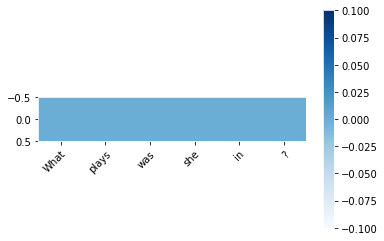

<Figure size 432x288 with 0 Axes>

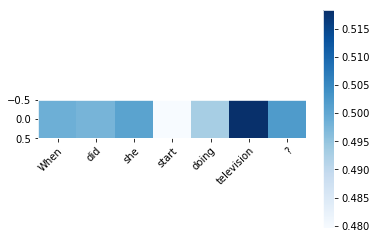

<Figure size 432x288 with 0 Axes>

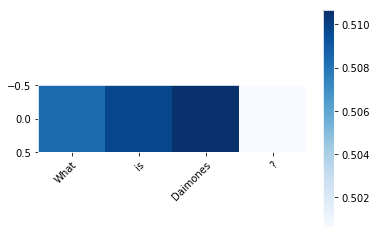

<Figure size 432x288 with 0 Axes>

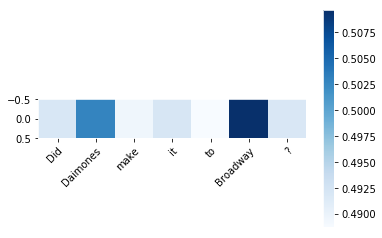

<Figure size 432x288 with 0 Axes>

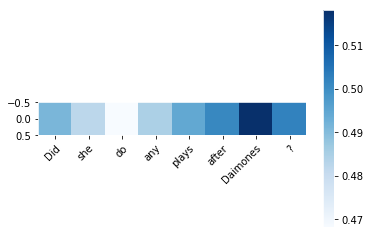

<Figure size 432x288 with 0 Axes>

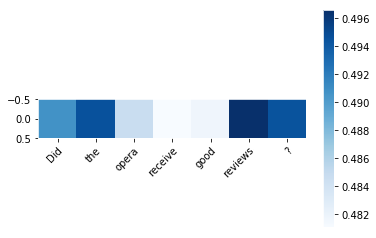

<Figure size 432x288 with 0 Axes>

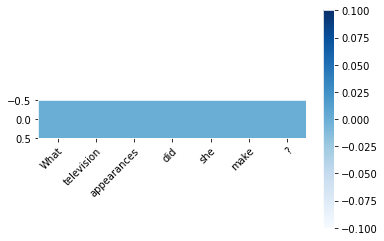

<Figure size 432x288 with 0 Axes>

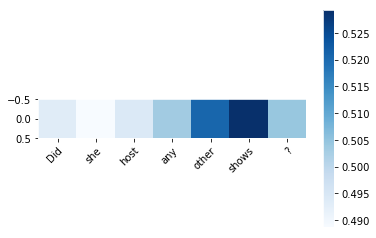

<Figure size 432x288 with 0 Axes>

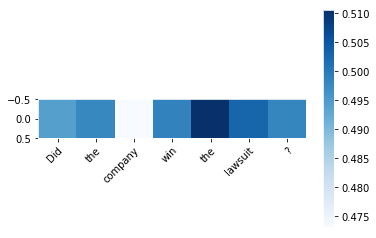

<Figure size 432x288 with 0 Axes>

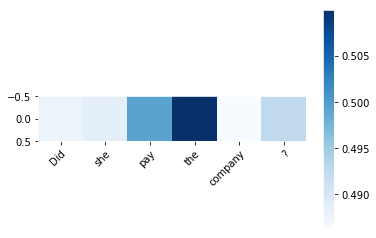

In [38]:
if pred['ant_scores'][0] != None:
    ant_scores = np.array(pred['ant_scores'])
    for i, qa in enumerate(data[EXAMPLE_IX]['paragraphs'][0]['qas']):
        a_scores = ant_scores[i, :, 0].reshape((1, ant_scores.shape[1]))
        plt.figure()
        fig, ax1 = plt.subplots(1,1)
        a_scores = a_scores[:, :len(pred['question_tokens'][i])]
        heatmap = ax1.imshow(a_scores, cmap="Blues", interpolation='nearest')
        ax1.set_xticks(np.arange(len(pred['question_tokens'][i])))
        ax1.set_xticklabels(pred['question_tokens'][i])
        plt.setp(ax1.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")
        plt.colorbar(heatmap)
        plt.show()


MENTION SCORES

Turn 1


<Figure size 432x288 with 0 Axes>

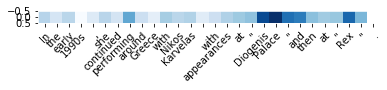

Turn 2


<Figure size 432x288 with 0 Axes>

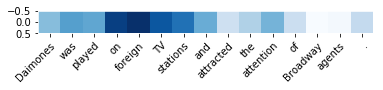

Turn 3


<Figure size 432x288 with 0 Axes>

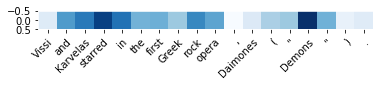

Turn 4


<Figure size 432x288 with 0 Axes>

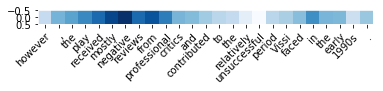

Turn 5


<Figure size 432x288 with 0 Axes>

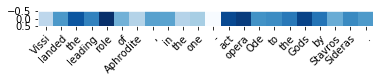

Turn 7


<Figure size 432x288 with 0 Axes>

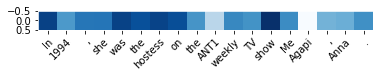

Turn 8


<Figure size 432x288 with 0 Axes>

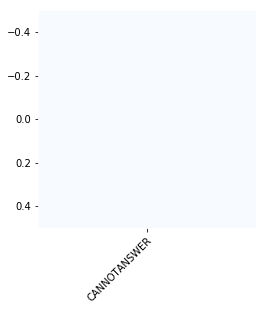

Turn 9


<Figure size 432x288 with 0 Axes>

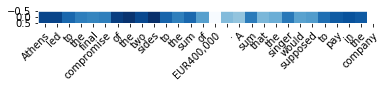

In [39]:
print('''
MENTION SCORES
''')

if pred['men_scores_a'][0] != None:
    men_scores_a = np.array(pred['men_scores_a'])
    men_scores_q = np.array(pred['men_scores_q'])
    for i in range(1,len(data[EXAMPLE_IX]['paragraphs'][0]['qas'])):
        if np.all(followups[i-1] == 'y'):
            print('Turn {}'.format(i))
            a_scores = men_scores_a[0, i, :, 0].reshape((1, men_scores_a.shape[2]))
            q_scores = men_scores_q[0, i, :, 0].reshape((1, men_scores_q.shape[2]))

    #         plt.figure()
    #         fig, ax1 = plt.subplots(1,1)
    #         q_scores = q_scores[:, :len(pred['question_tokens'][i-1])]
    #         heatmap = ax1.imshow(q_scores, cmap="Blues", interpolation='nearest')
    #         ax1.set_xticks(np.arange(len(pred['question_tokens'][i-1])))
    #         ax1.set_xticklabels(pred['question_tokens'][i-1])
    #         plt.setp(ax1.get_xticklabels(), rotation=45, ha="right",
    #              rotation_mode="anchor")
    #         plt.colorbar(heatmap)
    #         plt.show()

            plt.figure()
            fig, ax1 = plt.subplots(1,1)
            a_scores = a_scores[:, :len(split_tokens(pred['answer_tokens'][i-1][0]))]
            heatmap = ax1.imshow(a_scores, cmap="Blues", interpolation='nearest')
            ax1.set_xticks(np.arange(len(split_tokens(pred['answer_tokens'][i-1][0]))))
            ax1.set_xticklabels(split_tokens(pred['answer_tokens'][i-1][0]))
            plt.setp(ax1.get_xticklabels(), rotation=45, ha="right",
                 rotation_mode="anchor")
    #         plt.colorbar(heatmap)
            plt.show()

 TURN : 1 
Question (t-1) attention


<Figure size 576x576 with 0 Axes>

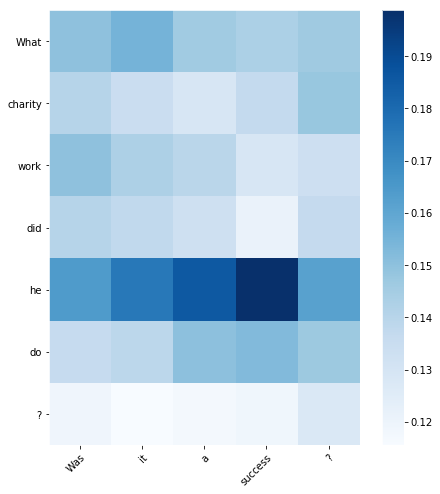

 TURN : 2 
 TURN : 3 
Question (t-1) attention


<Figure size 576x576 with 0 Axes>

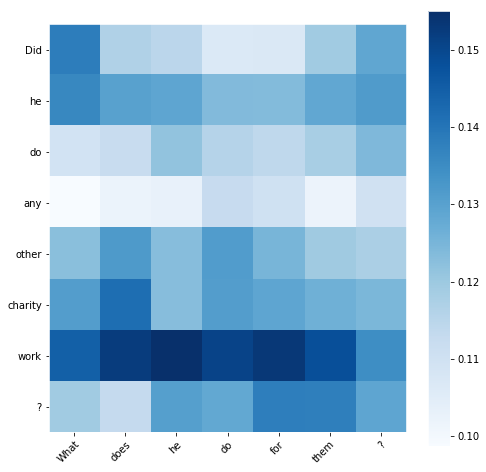

 TURN : 4 
Question (t-1) attention


<Figure size 576x576 with 0 Axes>

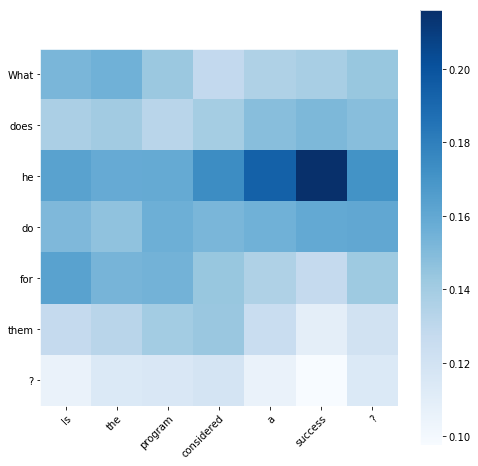

 TURN : 5 
Question (t-1) attention


<Figure size 576x576 with 0 Axes>

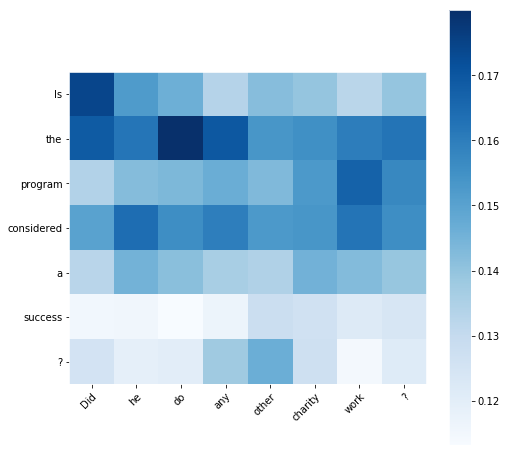

 TURN : 6 
Question (t-1) attention


<Figure size 576x576 with 0 Axes>

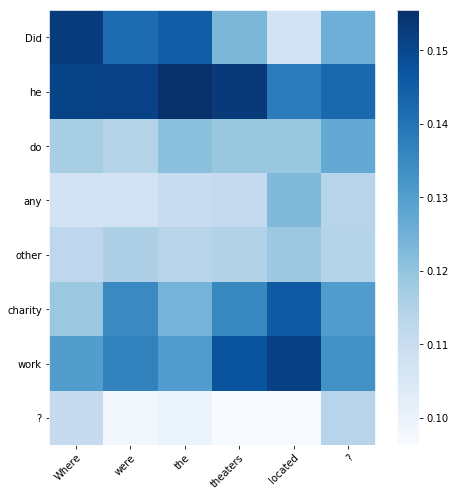

 TURN : 7 
Question (t-1) attention


<Figure size 576x576 with 0 Axes>

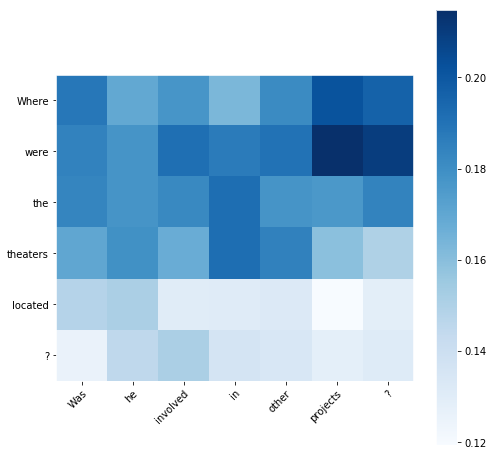

In [17]:
import numpy as np


for turn in range(1, sm_att_qs.shape[1]):
    print(""" TURN : {} """.format(turn))
    for prev_turn in range(NUM_TURNS - 1, -1, -1):
        if np.all(followups[turn - prev_turn - 1:turn] == 'y'):
            print("Question (t-{}) attention".format(prev_turn + 1))
            _ = plot_attention(sm_att_qs[prev_turn, turn, :, :].T, pred['question_tokens'][turn - prev_turn - 1], pred['question_tokens'][turn], (8,8))


 TURN : 1 
Answer (t-1) attention
(27, 8)


<Figure size 720x1008 with 0 Axes>

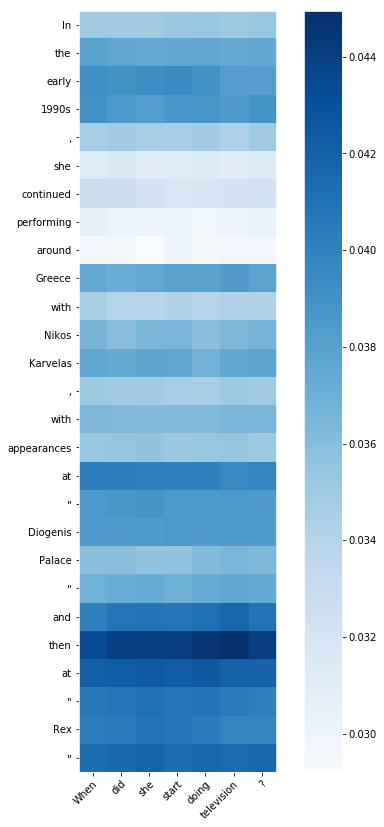

Keywords:  then, at, ", and, "
 TURN : 2 
Answer (t-1) attention
(27, 8)


<Figure size 720x1008 with 0 Axes>

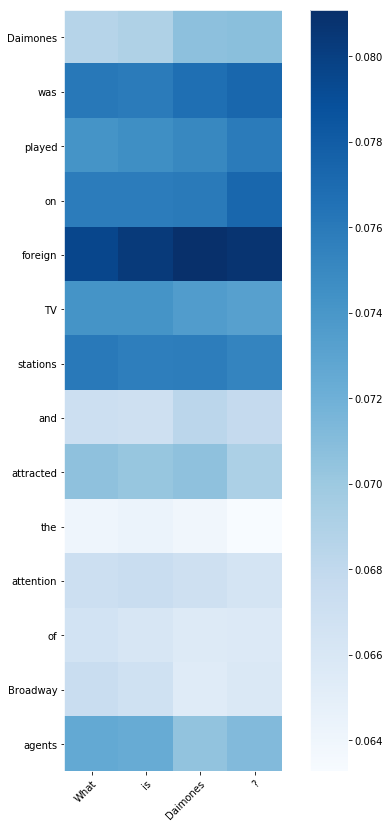

Keywords:  foreign, was, on, played, stations
 TURN : 3 
Answer (t-1) attention
(27, 8)


<Figure size 720x1008 with 0 Axes>

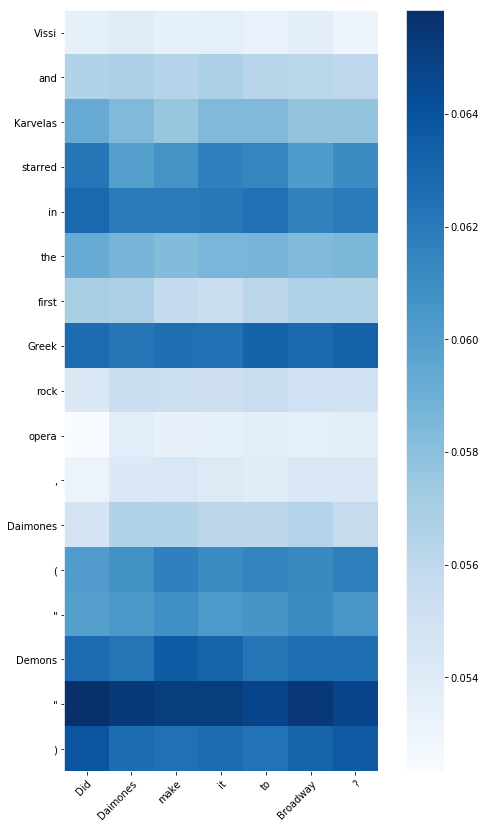

Keywords:  ", ), Demons, Greek, in
 TURN : 4 
Answer (t-1) attention
(27, 8)


<Figure size 720x1008 with 0 Axes>

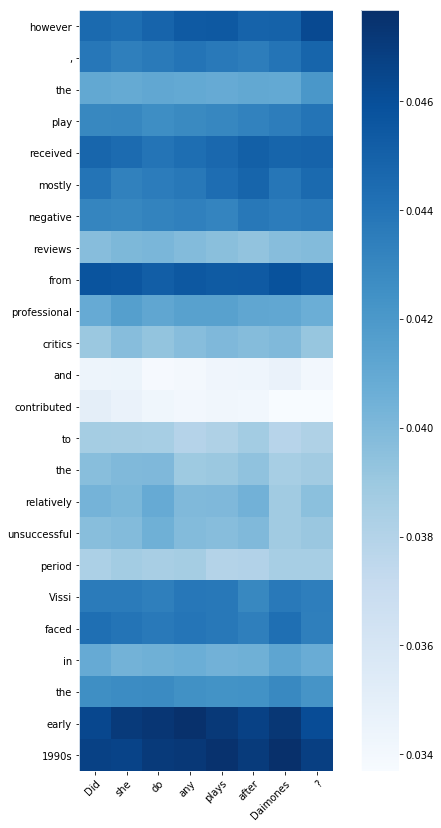

Keywords:  1990s, early, from, however, received
 TURN : 5 
Answer (t-1) attention
(27, 8)


<Figure size 720x1008 with 0 Axes>

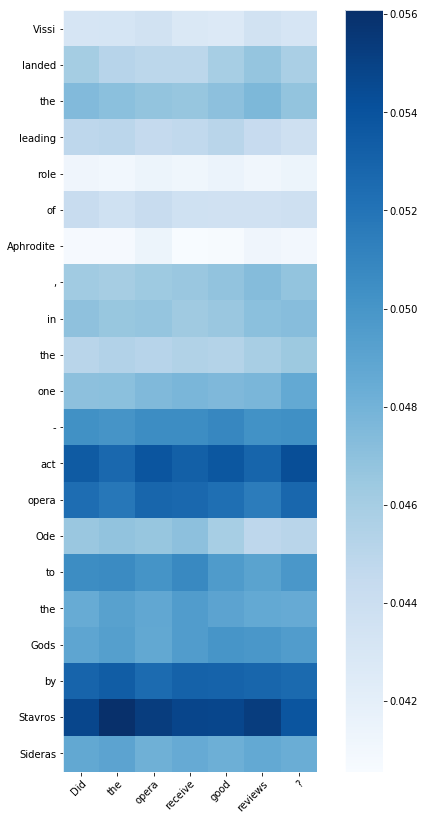

Keywords:  Stavros, act, by, opera, -
 TURN : 6 
 TURN : 7 
Answer (t-1) attention
(27, 8)


<Figure size 720x1008 with 0 Axes>

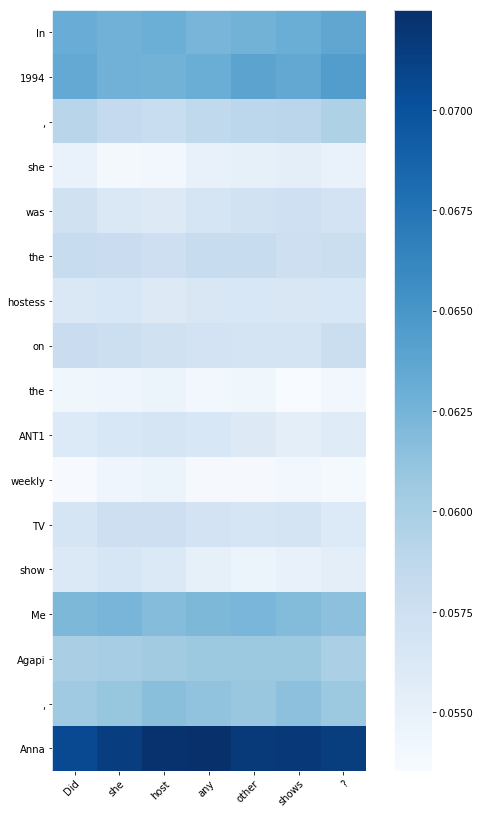

Keywords:  Anna, 1994, In, Me, ,
 TURN : 8 
Answer (t-1) attention
(27, 8)


/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_base.py:3471: UserWarning: Attempting to set identical bottom==top results
in singular transformations; automatically expanding.
bottom=-0.5, top=-0.5
  'bottom=%s, top=%s') % (bottom, top))


<Figure size 720x1008 with 0 Axes>

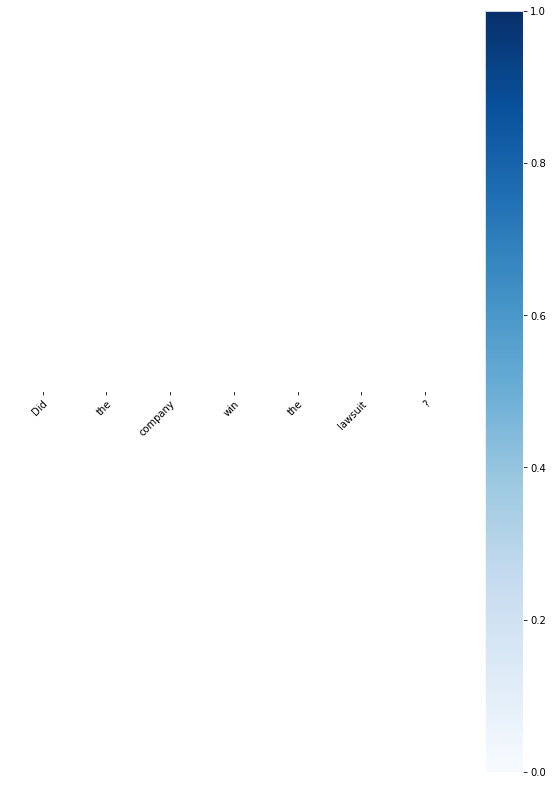

IndexError: list index out of range

In [39]:
import spacy
nlp = spacy.load('en_core_web_sm')

def _remove_spaces(tokens):
    return [token for token in tokens if not token.is_space]

def split_tokens(s):
    return [x.text for x in _remove_spaces(nlp(s))]

followups = np.array([qa['followup'] for qa in data[EXAMPLE_IX]['paragraphs'][0]['qas']])
for turn in range(1, sm_att_qs.shape[1]):
    print(""" TURN : {} """.format(turn))
    for prev_turn in range(NUM_TURNS - 1, -1, -1):
        if np.all(followups[turn - prev_turn - 1:turn] == 'y'):
            print("Answer (t-{}) attention".format(prev_turn + 1))
            print(sm_att_as[prev_turn, turn, :, :].T.shape)
            ans_tokens = split_tokens(pred['answer_tokens'][turn - prev_turn - 1][0])[:-1]
            _ = plot_attention(sm_att_as[prev_turn, turn, :, :].T, split_tokens(pred['answer_tokens'][turn - prev_turn - 1][0])[:-1], pred['question_tokens'][turn], (10,14))
            keyword_scores = np.sum(sm_att_as[prev_turn, turn, :, :], 0)
            max_scores_ix = np.argsort(keyword_scores)[-5:][::-1]
            print("Keywords: ", ', '.join([ans_tokens[i] for i in max_scores_ix]))


In [13]:
if NUM_TURNS > 1:
    print("Hierarchical Attention")
    _ = plot_attention(weights_qa[:, turn, :],
                       ['t - ' + str(i + 1) for i in range(NUM_TURNS)],
                       pred['question_tokens'][turn],
                       (10,10))


    NUM_TURNS = weights_qa.shape[0]
    _ = plot_attention(weights_qq[:, turn, :],
                       ['t - ' + str(i + 1) for i in range(NUM_TURNS)],
                       pred['question_tokens'][turn],
                       (10,10))



## Metrics to get

1. % of time turn t - k gets highest attention score
2. histogram of num_followups in dialog snippets
3. 

In [27]:
sm_att_as[0,1,0,:].sum()

1.000000175088644